In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.5})

In [2]:
import phconvert as phc
print('phconvert version: ', phc.__version__)

phconvert version:  0.7.3+21.g9ade74b


In [3]:
import polimi_tcspc

# Convert POLIMI-TCSPC to Photon-HDF5

## Define the input data file

You need to paste the full path of your POLIMI-TCSPC file in the following cell, 
between single quotes `'`.

> **NOTE**: if your path contains the `'` character please use `"` as string delimiter.

In [4]:
filename = r'E:\Data\Antonio\data\POLIMI-TCSPC-16ch\Xavier\2015-8-14\Manta_TCSPC_16ch_USB_Dark Counts_0.dat'

In [5]:
filename = r'E:\Data\Antonio\data\POLIMI-TCSPC-16ch/2015-08-28/DCR_2.dat'

The next cell will check whether the `filename` location is correct:

In [6]:
import os
try: 
    with open(filename): pass
    print('Data file found, you can proceed.')
except IOError:
    print('ATTENTION: Data file not found, please check the filename.\n'
          '           (current value "%s")' % filename)

Data file found, you can proceed.


In case of file not found, please double check that have you put the example 
data files in the "data" folder, or that the path you have pasted in `filename`
is correct. Please re-execute the last two cells until the file is found.

## Data description

In the next few cells, we specify the additional metadata that will be stored 
in the Photon-HDF5 file.

In [8]:
description = ('Short DCR measurement of 16CH TCSPC manta')

Please edit the previous cells and execute them (SHIFT+ENTER) to make sure 
there are no errors. Then proceed to the next section.

## Reading the data file

In [9]:
data, header_info = polimi_tcspc.loadfile(filename)

In [10]:
header_info.keys()

dict_keys(['tcspc_offset_ns', 'tcspc_binwidths_ps', 'timestamps_clock_Hz', 'num_channels', 'label'])

In [11]:
for name in ['label', 'num_channels', 'timestamps_clock_Hz']:
    if name in header_info:
        print('%s: %s' % (name, header_info[name]))

label: b'POLIMI TCSPC-16CH v001'
num_channels: 16
timestamps_clock_Hz: 20000000.0


## Channels plot

In [12]:
channels = data['channels']

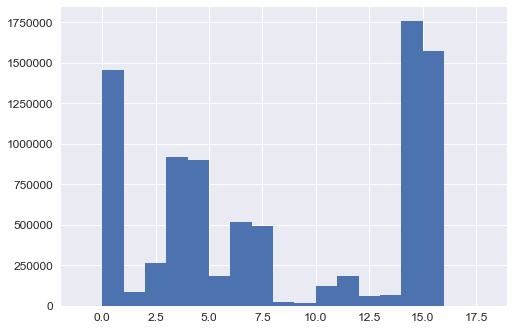

In [13]:
plt.hist(channels+0.5, bins=np.arange(-1, 19));

In [14]:
print("Channel     Counts")
print("-------     -------")
for ch, count in zip(*np.unique(channels, return_counts=True)):
    print("%8d   %8d" % (ch, count))

Channel     Counts
-------     -------
       0    1454824
       1      84517
       2     263034
       3     917226
       4     898177
       5     186296
       6     515559
       7     490975
       8      21374
       9      17132
      10     120418
      11     185894
      12      60051
      13      69389
      14    1757874
      15    1571428


## Timestamps plots


In [15]:
timestamps_m = data['timestamps']

In [16]:
type(timestamps_m)

list

In [ ]:
for ts in timestamps_m:
    plt.plot(ts)

In [ ]:
for ts in timestamps_m:
    plt.plot(ts[:10], marker='h')

## nanotimes plots

In [ ]:
nanotimes = data['nanotimes']

In [ ]:
binw_ns = np.array(header_info['tcspc_binwidths_ps'])*1e-3

In [ ]:
bins_r = np.arange(2**14 + 1) 
for ch in range(16):
    plt.hist(nanotimes[channels == ch]*binw_ns[ch], bins_r[::4]*binw_ns[ch], 
             histtype='step', lw=1.5, alpha=0.7, label='CH %d' % ch)
    plt.xlabel('TCSPC nanotime (ns)')
plt.legend()
#plt.yscale('log');

In [ ]:
nanotimes.min(), nanotimes.max()

## Prepare data-structure for saving

In [ ]:
#tcspc_binwidths_ps_module1 = pd.DataFrame.from_csv('polimi_tcspc_binwidths.txt')
#tcspc_binwidths_ps_module1.T

In [ ]:
timestamps_unit = 1/header_info['timestamps_clock_Hz']
acquisition_duration = (np.max([t.max() for t in timestamps_m]) - np.min([t.min() for t in timestamps_m]))*timestamps_unit

In [ ]:
timestamps_unit, acquisition_duration

In [ ]:
np.min([t.min() for t in timestamps_m])*timestamps_unit

In [ ]:
d = {}
tcspc_num_bins = 2**14

for ch in range(16):
    ch_mask = channels == ch
    tcspc_unit = header_info['tcspc_binwidths_ps'][ch]*1e-12

    photon_data = dict(
        timestamps = timestamps_m[ch],
        timestamps_specs = dict(timestamps_unit=timestamps_unit),
        detectors = channels[ch_mask],

        nanotimes = nanotimes[ch_mask],

        nanotimes_specs = dict(
            tcspc_unit = tcspc_unit,
            tcspc_range = tcspc_unit*tcspc_num_bins,
            tcspc_num_bins = tcspc_num_bins),
    )
    d['photon_data%d' % ch] = photon_data

# File conversion

Once you finished editing the the previous sections you can proceed with
the actual conversion. It is suggested to execute the notebook in
one step by clicking on the menu *Cells* -> *Run All*.

After that, you should find a new `.hdf5` file in the same folder of the input
file. You can check it's content by using [HDFView](https://www.hdfgroup.org/products/java/hdfview/).

The cells below contain the code to convert the input file to Photon-HDF5.

## Add metadata

In [ ]:
d.update(
    description = description,
    acquisition_duration = acquisition_duration,
    _filename = filename,
    identity = dict(
        author = 'Antonino Ingargiola',
        author_affiliation = 'UCLA'
        ),
    setup = dict(
        num_pixels = header_info['num_channels'], 
        num_spots = header_info['num_channels'], 
        num_spectral_ch = 1, 
        num_polarization_ch = 1, 
        num_split_ch = 1,
        modulated_excitation = False, 
        lifetime = True, 
        excitation_alternated = (False,),
        excitation_wavelengths = (532e-9,),
        ),
    )

## Save to Photon-HDF5

This command saves the new file to disk. If the input data does not follows the Photon-HDF5 specification it returns an error (`Invalid_PhotonHDF5`) printing what violates the specs.

In [ ]:
phc.hdf5.save_photon_hdf5(d, overwrite=True)

## Load Photon-HDF5

Finally we try to reload the file to check that there are no errors.

In [ ]:
from pprint import pprint

In [ ]:
filename = d['_data_file'].filename

In [ ]:
h5data = phc.hdf5.load_photon_hdf5(filename)

In [ ]:
phc.hdf5.dict_from_group(h5data.identity)

In [ ]:
phc.hdf5.dict_from_group(h5data.setup)

In [ ]:
pprint(phc.hdf5.dict_from_group(h5data.photon_data0))

In [ ]:
h5data._v_file.close()

If the next cell output shows "OK" then the execution is terminated.

In [ ]:
print('OK')